In [28]:
import pandas as pd
import numpy as np
import calendar
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy.stats import randint
from sklearn.linear_model import LinearRegression
import os
import pickle
import gradio as gr

In [30]:
sales_data = pd.read_excel('GH_UK_2011_to_2013.xlsx', sheet_name='sales_UK_2011_to_2013') 
other_features = pd.read_excel('GH_UK_2011_to_2013.xlsx', sheet_name='Other_Features')   

In [9]:
print(sales_data.info())
print(other_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440256 entries, 0 to 440255
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    440256 non-null  int64         
 1   stock_code    440256 non-null  object        
 2   description   440256 non-null  object        
 3   quantity      440256 non-null  int64         
 4   invoice_date  440256 non-null  datetime64[ns]
 5   unit_price    440256 non-null  float64       
 6   customer_id   440256 non-null  int64         
 7   country       440256 non-null  object        
 8   total_sales   440256 non-null  float64       
 9   year          440256 non-null  int64         
 10  month         440256 non-null  int64         
 11  season        440256 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 40.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (tota

In [10]:
# Print the first few rows of the DataFrame
print(sales_data.head(3))

# Count distinct values
distinct_count = sales_data['stock_code'].nunique()
print("Distinct stock_code count:", distinct_count)

distinct_count2 = sales_data['description'].nunique()
print("Distinct description count:", distinct_count2)

# Investigate the mismatch
# Create a DataFrame with unique combinations of stock_code and description
unique_combinations = sales_data[['stock_code', 'description']].drop_duplicates()

# check for any stock_code that has multiple descriptions
mismatched_stock_codes = unique_combinations.groupby('stock_code').filter(lambda x: len(x) > 1)
print(mismatched_stock_codes.info())

# further investigation
mismatched_codes_list = mismatched_stock_codes.iloc[:, 0].tolist() 

# Filter the unique_combinations DataFrame for stock codes in mismatched_codes_list
filtered_data = unique_combinations[unique_combinations['stock_code'].isin(mismatched_codes_list)]

# Group by stock_code and aggregate descriptions
grouped_data = filtered_data.groupby('stock_code')['description'].apply(list).reset_index()

# Set display options to show the full text of the DataFrame
pd.set_option('display.max_colwidth', None)  # None means no limit on column width

# Print the grouped data
print(grouped_data.sample(5)['description'])

# Reset the display options to default after printing
pd.reset_option('display.max_colwidth')

   invoice_no stock_code                     description  quantity  \
0      558371      20723        strawberry charlotte bag        37   
1      580610      20726              lunch bag woodland         4   
2      547772      22293  hanging chick green decoration         2   

  invoice_date  unit_price  customer_id         country  total_sales  year  \
0   2011-06-28        2.46            0  United Kingdom        91.02  2011   
1   2011-12-05        4.13            0  United Kingdom        16.52  2011   
2   2011-03-25        1.45        17979  United Kingdom         2.90  2011   

   month  season  
0      6  Summer  
1     12  Winter  
2      3  Spring  
Distinct stock_code count: 3765
Distinct description count: 3852
<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 7 to 437548
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   stock_code   379 non-null    object
 1   description  379 non-null    object

In [11]:
# Group the sales data by `stock_code` and `invoice_date` to get daily sales
daily_sales = sales_data.groupby(['invoice_date', 'stock_code']).agg({'total_sales': 'sum'}).reset_index()

# Extract year, month, and day from `invoice_date`
daily_sales['year'] = daily_sales['invoice_date'].dt.year
daily_sales['month'] = daily_sales['invoice_date'].dt.month
daily_sales['day'] = daily_sales['invoice_date'].dt.day  # Extract day

# Ensure 'year' and 'month' in other_features are integers
other_features['year'] = other_features['year'].astype(int)
other_features['month'] = other_features['month'].astype(int)

# Expand monthly data into daily data dynamically
expanded_rows = []

for _, row in other_features.iterrows():
    year, month = row['year'], row['month']
    days_in_month = calendar.monthrange(year, month)[1]  # Get actual number of days in the month
    
    # Create daily entries for each day in the month
    for day in range(1, days_in_month + 1):
        new_row = row.copy()
        new_row['day'] = day  # Assign day
        
        # Divide numeric values by the number of days to distribute them evenly
        for col in ['CPI', 'GDP', 'VALUE OF RETAIL SALES', 'VALUE OF Internet Sales ']:
            new_row[col] /= days_in_month  # Normalize monthly values
        
        # Assign Holiday & Seasonal Trends **only on the correct date**
        if day == 1:  
            new_row['Holiday and Seasonal Trends'] = row['Holiday and Seasonal Trends']  # Assign only to 1st
        else:
            new_row['Holiday and Seasonal Trends'] = np.nan  # Keep other days empty
        
        expanded_rows.append(new_row)

# Create a new DataFrame with daily features
daily_features = pd.DataFrame(expanded_rows)

# Merge daily features with daily sales using year, month, and day
daily_sales = daily_sales.merge(daily_features, on=['year', 'month', 'day'], how='left')

# Drop unnecessary columns
daily_sales.drop(columns=['year', 'month', 'day'], inplace=True)

In [12]:
print(daily_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338669 entries, 0 to 338668
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   invoice_date                 338669 non-null  datetime64[ns]
 1   stock_code                   338669 non-null  object        
 2   total_sales                  338669 non-null  float64       
 3   CPI                          338669 non-null  float64       
 4   GDP                          338669 non-null  float64       
 5   VALUE OF RETAIL SALES        338669 non-null  float64       
 6   VALUE OF Internet Sales      338669 non-null  float64       
 7   Holiday and Seasonal Trends  6766 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 20.7+ MB
None


In [13]:
# Step 1: Group by 'stock_code' and sum 'total_sales'
grouped_sales = daily_sales.groupby('stock_code')['total_sales'].sum().reset_index()

# Step 2: Calculate the threshold for the top 70%
threshold = grouped_sales['total_sales'].quantile(0.7)

# Step 3: Filter the DataFrame for the top items
top_items = grouped_sales[grouped_sales['total_sales'] >= threshold]


top_items = daily_sales[daily_sales['stock_code'].isin(top_items['stock_code'])]

In [14]:
print(top_items.info())
print(top_items.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 227962 entries, 1 to 338646
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   invoice_date                 227962 non-null  datetime64[ns]
 1   stock_code                   227962 non-null  object        
 2   total_sales                  227962 non-null  float64       
 3   CPI                          227962 non-null  float64       
 4   GDP                          227962 non-null  float64       
 5   VALUE OF RETAIL SALES        227962 non-null  float64       
 6   VALUE OF Internet Sales      227962 non-null  float64       
 7   Holiday and Seasonal Trends  4721 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 15.7+ MB
None
Index(['invoice_date', 'stock_code', 'total_sales', 'CPI', 'GDP',
       'VALUE OF RETAIL SALES', 'VALUE OF Internet Sales ',
       'Holiday and Seasonal Tre

In [22]:
# Preprocess the data
# Convert 'invoice_date' to datetime
top_items['invoice_date'] = pd.to_datetime(top_items['invoice_date'])

# Step 2: Aggregate monthly total_sales for each stock_code while keeping all columns
monthly_sales = top_items.groupby(['stock_code', top_items['invoice_date'].dt.to_period('M')]).agg(
    total_sales=('total_sales', 'sum'),
    CPI=('CPI', 'first'),
    GDP=('GDP', 'first'),
    VALUE_OF_RETAIL_SALES=('VALUE OF RETAIL SALES', 'first'),
    VALUE_OF_Internet_Sales=('VALUE OF Internet Sales ', 'first'),
    Holiday_and_Seasonal_Trends=('Holiday and Seasonal Trends', 'first')
).reset_index()

# Convert the period back to a timestamp for the index
monthly_sales['invoice_date'] = monthly_sales['invoice_date'].dt.to_timestamp()

# Set the 'invoice_date' as the index
monthly_sales.set_index('invoice_date', inplace=True)

# Step 3: Prepare features and labels
# Encode categorical features
label_encoder = LabelEncoder()
monthly_sales['stock_code'] = monthly_sales['stock_code'].astype(str)
monthly_sales['stock_code'] = label_encoder.fit_transform(monthly_sales['stock_code'])

# One-hot encoding for 'Holiday and Seasonal Trends'
encoder = OneHotEncoder(sparse=False)
holiday_encoded = encoder.fit_transform(monthly_sales[['Holiday_and_Seasonal_Trends']])
holiday_df = pd.DataFrame(holiday_encoded, columns=encoder.get_feature_names_out(['Holiday_and_Seasonal_Trends']))

# Reset index to avoid InvalidIndexError
monthly_sales.reset_index(inplace=True)

# Concatenate the one-hot encoded columns with the original DataFrame
monthly_sales = pd.concat([monthly_sales, holiday_df], axis=1)

# Drop the original 'Holiday and Seasonal Trends' column
monthly_sales.drop(columns=['Holiday_and_Seasonal_Trends'], inplace=True)

# Set the 'invoice_date' back as the index if needed
monthly_sales.set_index('invoice_date', inplace=True)

# Prepare features and labels
X = monthly_sales[['stock_code', 'CPI', 'GDP', 'VALUE_OF_RETAIL_SALES', 'VALUE_OF_Internet_Sales'] + list(holiday_df.columns)].values
y = monthly_sales['total_sales'].values

/var/folders/ms/r79cd99d3673p095x2_48c_00000gn/T/ipykernel_84775/3046846140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_items['invoice_date'] = pd.to_datetime(top_items['invoice_date'])
/Users/doradeng/tensorflow-test/env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
print(monthly_sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33570 entries, 2011-01-01 to 2013-03-01
Data columns (total 13 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   stock_code                                                   33570 non-null  int64  
 1   total_sales                                                  33570 non-null  float64
 2   CPI                                                          33570 non-null  float64
 3   GDP                                                          33570 non-null  float64
 4   VALUE_OF_RETAIL_SALES                                        33570 non-null  float64
 5   VALUE_OF_Internet_Sales                                      33570 non-null  float64
 6   Holiday_and_Seasonal_Trends_Back to School                   33570 non-null  float64
 7   Holiday_and_Seasonal_Trends_Bank Holiday                   

In [26]:

# preprocess for transformer model 

#**Create Sequences**: Define a function to create sequences for time series forecasting.

def create_sequences(X, y, seq_length):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        labels.append(y[i + seq_length])  # Predicting the next time step
    return np.array(sequences), np.array(labels)

seq_length = 10 
X_, y_ = create_sequences(X, y, seq_length)
   
  
# Split the data into training, validation, and testing sets based on time
train_size = int(len(X_) * 0.6)  # 60% for training
val_size = int(len(X_) * 0.2)     # 20% for validation
test_size = len(X_) - train_size - val_size  # Remaining 20% for testing

TR_X_train, TR_y_train = X_[:train_size], y_[:train_size]
TR_X_val, TR_y_val = X_[train_size:train_size + val_size], y_[train_size:train_size + val_size]
TR_X_test, TR_y_test = X_[train_size + val_size:], y_[train_size + val_size:]

# Note: No random_state is used here to maintain the temporal order

scaler_y_ = MinMaxScaler()
TR_y_train = scaler_y_.fit_transform(TR_y_train.reshape(-1, 1)).flatten()
TR_y_val = scaler_y_.transform(TR_y_val.reshape(-1, 1)).flatten()
TR_y_test = scaler_y_.transform(TR_y_test.reshape(-1, 1)).flatten()

# Initialize the scaler
scaler_X_ = MinMaxScaler()


scaler_X_.fit(TR_X_train.reshape(-1, TR_X_train.shape[-1]))  # Fit on training set only

TR_X_train_scaled = scaler_X_.transform(TR_X_train.reshape(-1, TR_X_train.shape[-1])).reshape(TR_X_train.shape)
TR_X_val_scaled = scaler_X_.transform(TR_X_val.reshape(-1, TR_X_val.shape[-1])).reshape(TR_X_val.shape)
TR_X_test_scaled = scaler_X_.transform(TR_X_test.reshape(-1, TR_X_test.shape[-1])).reshape(TR_X_test.shape)

In [28]:
# Define the Transformer model
def create_transformer_model(input_shape, num_heads, ff_dim, num_classes):
    inputs = layers.Input(shape=(input_shape[0], input_shape[1]))  # (sequence_length, num_features)
    
    # Encoder
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Residual connection
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Conv1D(filters=input_shape[1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Residual connection
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Add a Dense layer with increased L2 regularization and Dropout
    units = 16  # Reduced number of units
    x = layers.Dense(units, activation='relu', kernel_regularizer=l2(1e-1))(x)  # Increased L2 regularization
    x = layers.Dropout(0.4)(x)  # Added Dropout layer
    x = layers.BatchNormalization()(x)  # Added Batch Normalization

        
    # Output layer - no activation for regression
    outputs = layers.Dense(num_classes)(x)  # Predicting total sales as a single value
    
    TR_model = models.Model(inputs=inputs, outputs=outputs)
    return TR_model
    
# Parameters
input_shape = (TR_X_train_scaled.shape[1], TR_X_train_scaled.shape[2])  # (sequence_length, num_features)
num_heads = 2
ff_dim = 16
num_classes = 1  # Predicting total sales as a single value


# Define a custom learning rate
learning_rate = 0.0001  # Consider using a higher value

# Create KFold object
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results
fold_losses = []
fold_maes = []

# Initialize lists to store loss values for each fold
all_train_losses = []
all_val_losses = []

# K-Fold Cross Validation
for train_index, val_index in kf.split(TR_X_train_scaled):
    X_train_fold, X_val_fold = TR_X_train[train_index], TR_X_train[val_index]
    y_train_fold, y_val_fold = TR_y_train[train_index], TR_y_train[val_index]

    # Create the Transformer model
    TR_model = create_transformer_model(input_shape, num_heads, ff_dim, num_classes)

    # Use the Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)  

    # Compile the model with the custom optimizer
    TR_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # Define the learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the Transformer model with early stopping
    history = TR_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        callbacks=[early_stopping, lr_scheduler], verbose=1) 
    
    # Append the training and validation loss for this fold
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])

    # Evaluate the model on the validation set
    val_loss, val_mae = TR_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(val_loss)
    fold_maes.append(val_mae)


# Average the losses across all folds
avg_train_loss = np.mean(all_train_losses, axis=0)
avg_val_loss = np.mean(all_val_losses, axis=0)

# Print average results across all folds
print(f'Average Training Loss (MSE) across {k} folds: {avg_train_loss[-1]}')  # Last epoch's average training loss
print(f'Average Validation Loss (MSE) across {k} folds: {avg_val_loss[-1]}')  # Last epoch's average validation loss
print(f'Average Validation MAE across {k} folds: {np.mean(fold_maes)}')  # Overall average MAE across folds


2025-02-14 04:17:57.567654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-14 04:17:57.567711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-02-14 04:17:59.054666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-14 04:17:59.153764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


504/504 [==============================] - ETA: 0s - loss: 1.7225 - mae: 0.5857

2025-02-14 04:18:12.587557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 16s 22ms/step - loss: 1.7225 - mae: 0.5857 - val_loss: 1.0662 - val_mae: 0.2779 - lr: 1.0000e-04
Epoch 2/30
504/504 [==============================] - 10s 20ms/step - loss: 1.2233 - mae: 0.4747 - val_loss: 0.8564 - val_mae: 0.3476 - lr: 1.0000e-04
Epoch 3/30
504/504 [==============================] - 10s 20ms/step - loss: 0.8633 - mae: 0.3796 - val_loss: 0.5748 - val_mae: 0.2003 - lr: 1.0000e-04
Epoch 4/30
504/504 [==============================] - 10s 20ms/step - loss: 0.6294 - mae: 0.3306 - val_loss: 0.4116 - val_mae: 0.1735 - lr: 1.0000e-04
Epoch 5/30
504/504 [==============================] - 10s 20ms/step - loss: 0.4527 - mae: 0.2896 - val_loss: 0.2928 - val_mae: 0.1667 - lr: 1.0000e-04
Epoch 6/30
504/504 [==============================] - 10s 20ms/step - loss: 0.3213 - mae: 0.2540 - val_loss: 0.2018 - val_mae: 0.1509 - lr: 1.0000e-04
Epoch 7/30
504/504 [==============================] - 10s 20ms/step - loss: 0.2252 - mae: 0.2251 - val_lo

2025-02-14 04:23:07.433541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-14 04:23:07.525609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


504/504 [==============================] - ETA: 0s - loss: 2.6684 - mae: 0.9533

2025-02-14 04:23:17.625360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 12s 22ms/step - loss: 2.6684 - mae: 0.9533 - val_loss: 1.0271 - val_mae: 0.1353 - lr: 1.0000e-04
Epoch 2/30
504/504 [==============================] - 10s 20ms/step - loss: 1.9086 - mae: 0.7738 - val_loss: 0.7810 - val_mae: 0.1236 - lr: 1.0000e-04
Epoch 3/30
504/504 [==============================] - 10s 20ms/step - loss: 1.3669 - mae: 0.6336 - val_loss: 0.5866 - val_mae: 0.1033 - lr: 1.0000e-04
Epoch 4/30
504/504 [==============================] - 10s 20ms/step - loss: 0.9584 - mae: 0.4972 - val_loss: 0.4390 - val_mae: 0.1159 - lr: 1.0000e-04
Epoch 5/30
504/504 [==============================] - 10s 20ms/step - loss: 0.7095 - mae: 0.4251 - val_loss: 0.3177 - val_mae: 0.0684 - lr: 1.0000e-04
Epoch 6/30
504/504 [==============================] - 10s 20ms/step - loss: 0.5135 - mae: 0.3657 - val_loss: 0.2252 - val_mae: 0.0348 - lr: 1.0000e-04
Epoch 7/30
504/504 [==============================] - 10s 20ms/step - loss: 0.3737 - mae: 0.3188 - val_lo

2025-02-14 04:28:14.017717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-14 04:28:14.109788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


504/504 [==============================] - ETA: 0s - loss: 3.3162 - mae: 1.1052

2025-02-14 04:28:23.199004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 11s 20ms/step - loss: 3.3162 - mae: 1.1052 - val_loss: 1.1561 - val_mae: 0.1430 - lr: 1.0000e-04
Epoch 2/30
504/504 [==============================] - 10s 19ms/step - loss: 2.3188 - mae: 0.9131 - val_loss: 0.8503 - val_mae: 0.0426 - lr: 1.0000e-04
Epoch 3/30
504/504 [==============================] - 10s 19ms/step - loss: 1.5928 - mae: 0.7386 - val_loss: 0.6502 - val_mae: 0.0285 - lr: 1.0000e-04
Epoch 4/30
504/504 [==============================] - 10s 19ms/step - loss: 1.1326 - mae: 0.6153 - val_loss: 0.4942 - val_mae: 0.0270 - lr: 1.0000e-04
Epoch 5/30
504/504 [==============================] - 10s 19ms/step - loss: 0.8071 - mae: 0.5017 - val_loss: 0.3723 - val_mae: 0.0311 - lr: 1.0000e-04
Epoch 6/30
504/504 [==============================] - 10s 19ms/step - loss: 0.5840 - mae: 0.4139 - val_loss: 0.2759 - val_mae: 0.0365 - lr: 1.0000e-04
Epoch 7/30
504/504 [==============================] - 10s 19ms/step - loss: 0.4295 - mae: 0.3548 - val_lo

2025-02-14 04:33:11.355401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-14 04:33:11.447776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


504/504 [==============================] - ETA: 0s - loss: 2.4636 - mae: 0.8677

2025-02-14 04:33:21.849649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 12s 22ms/step - loss: 2.4636 - mae: 0.8677 - val_loss: 1.3158 - val_mae: 0.3876 - lr: 1.0000e-04
Epoch 2/30
504/504 [==============================] - 11s 21ms/step - loss: 1.6978 - mae: 0.7001 - val_loss: 0.9663 - val_mae: 0.3957 - lr: 1.0000e-04
Epoch 3/30
504/504 [==============================] - 10s 20ms/step - loss: 1.1841 - mae: 0.5760 - val_loss: 0.6898 - val_mae: 0.3574 - lr: 1.0000e-04
Epoch 4/30
504/504 [==============================] - 10s 21ms/step - loss: 0.8193 - mae: 0.4758 - val_loss: 0.4743 - val_mae: 0.2984 - lr: 1.0000e-04
Epoch 5/30
504/504 [==============================] - 10s 20ms/step - loss: 0.5564 - mae: 0.3913 - val_loss: 0.3234 - val_mae: 0.2570 - lr: 1.0000e-04
Epoch 6/30
504/504 [==============================] - 10s 21ms/step - loss: 0.3668 - mae: 0.3184 - val_loss: 0.2193 - val_mae: 0.2303 - lr: 1.0000e-04
Epoch 7/30
504/504 [==============================] - 10s 21ms/step - loss: 0.2356 - mae: 0.2585 - val_lo

2025-02-14 04:38:26.129783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-14 04:38:26.221533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


504/504 [==============================] - ETA: 0s - loss: 2.7216 - mae: 0.9793

2025-02-14 04:38:35.599257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


504/504 [==============================] - 11s 20ms/step - loss: 2.7216 - mae: 0.9793 - val_loss: 1.2119 - val_mae: 0.3155 - lr: 1.0000e-04
Epoch 2/30
504/504 [==============================] - 10s 20ms/step - loss: 1.6522 - mae: 0.6900 - val_loss: 0.8343 - val_mae: 0.0450 - lr: 1.0000e-04
Epoch 3/30
504/504 [==============================] - 10s 20ms/step - loss: 1.2001 - mae: 0.5772 - val_loss: 0.6162 - val_mae: 0.0370 - lr: 1.0000e-04
Epoch 4/30
504/504 [==============================] - 10s 20ms/step - loss: 0.8079 - mae: 0.4207 - val_loss: 0.4644 - val_mae: 0.1257 - lr: 1.0000e-04
Epoch 5/30
504/504 [==============================] - 10s 20ms/step - loss: 0.5555 - mae: 0.3189 - val_loss: 0.3367 - val_mae: 0.1206 - lr: 1.0000e-04
Epoch 6/30
504/504 [==============================] - 10s 20ms/step - loss: 0.4131 - mae: 0.2847 - val_loss: 0.2325 - val_mae: 0.0713 - lr: 1.0000e-04
Epoch 7/30
504/504 [==============================] - 10s 20ms/step - loss: 0.3002 - mae: 0.2514 - val_lo

In [29]:
# Train the model on the entire training set after K-Fold Cross Validation
TR_model.fit(TR_X_train_scaled, TR_y_train, epochs=30, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the validation set
val_loss, val_mae = TR_model.evaluate(TR_X_val_scaled, TR_y_val, verbose=0)

# Evaluate the model on the test set
test_loss, test_mae = TR_model.evaluate(TR_X_test_scaled, TR_y_test, verbose=0)

# Print the outcomes
print(f'Training MSE (last epoch): {avg_train_loss[-1]}')  # Assuming avg_train_loss is calculated during K-Fold
print(f'Validation MSE: {val_loss}')  # Validation loss (MSE)
print(f'Test Loss MSE: {test_loss}')  # Test loss (MSE)
print(f'Test MAE: {test_mae}')  # Test MAE

Epoch 1/30
630/630 [==============================] - 12s 18ms/step - loss: 0.0014 - mae: 0.0184
Epoch 2/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0181
Epoch 3/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0179
Epoch 4/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0180
Epoch 5/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0180
Epoch 6/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0178
Epoch 7/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0177
Epoch 8/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0177
Epoch 9/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0176
Epoch 10/30
630/630 [==============================] - 11s 18ms/step - loss: 0.0014 - mae: 0.0177
Epoch 11/30
630/630 [========

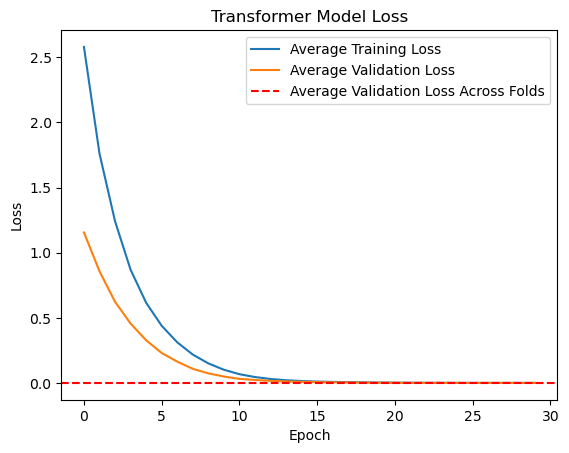

Final Transformer Average Training Loss: 0.001487854216247797
Final Transformer Average Validation Loss: 0.0014190083718858659
Final Transformer Average Validation Loss Across Folds: 0.0014190083718858659


In [30]:
# Plot training and validation loss values for the Transformer model
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.axhline(y=np.mean(fold_losses), color='r', linestyle='--', label='Average Validation Loss Across Folds')  # Add average validation loss as a horizontal line
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Print final loss values for comparison
print(f'Final Transformer Average Training Loss: {avg_train_loss[-1]}')
print(f'Final Transformer Average Validation Loss: {avg_val_loss[-1]}')
print(f'Final Transformer Average Validation Loss Across Folds: {np.mean(fold_losses)}')


In [38]:
def create_selected_lagged_features(X, y, lags):
  
    
    # Ensure X is a DataFrame
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    
    # Ensure y is a Series
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    # Initialize list with the original features
    lagged_dfs = [X]
    
    # Create and append the lagged features for each specified lag
    for lag in lags:
        lagged_df = X.shift(lag).add_suffix(f'_lag{lag}')
        lagged_dfs.append(lagged_df)
    
    # Concatenate all features along columns and drop rows with missing values
    X_lagged = pd.concat(lagged_dfs, axis=1).dropna()
    
    # Align the target variable y with the lagged features by selecting the matching indices
    y_lagged = y.loc[X_lagged.index]
    
    return X_lagged, y_lagged


# Compute Partial Autocorrelation for first 40 lags
pacf_values = pacf(y, nlags=40)  

# Select lags where PACF is significant (threshold: 0.1)
selected_lags = [i for i, val in enumerate(pacf_values) if abs(val) > 0.1]

# Use these selected lags in the function
X_lagged, y_lagged = create_selected_lagged_features(X, y, lags=selected_lags)


print(f'Features shape: {X_lagged.shape}')
print(f'Target shape: {y_lagged.shape}')

Features shape: (33558, 72)
Target shape: (33558,)


In [40]:
# Follow chronological splitting as Transformer model

train_size = int(len(X_lagged) * 0.6)
val_size = int(len(X_lagged) * 0.2)
test_size = len(X_lagged) - train_size - val_size

X_train, y_train = X_lagged[:train_size], y_lagged[:train_size]
X_val, y_val = X_lagged[train_size:train_size + val_size], y_lagged[train_size:train_size + val_size]
X_test, y_test = X_lagged[train_size + val_size:], y_lagged[train_size + val_size:]


# Check the sizes of the splits
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

# Flatten the input sequences for Random Forest and linear regression
X_train_flat = X_train.values.reshape(X_train.shape[0], -1)  # Convert to NumPy array and reshape
X_val_flat = X_val.values.reshape(X_val.shape[0], -1)        # Convert to NumPy array and reshape
X_test_flat = X_test.values.reshape(X_test.shape[0], -1)     # Convert to NumPy array and reshape

# Initialize the scaler for the target variable
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Convert Series to NumPy array
y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()          # Convert Series to NumPy array
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()        # Convert Series to NumPy array

Training set size: 20134
Validation set size: 6711
Test set size: 6713


In [42]:
#Create and train the Random Forest model

# Define the model
rf_model = RandomForestRegressor()

# Define the hyperparameters and their distributions to sample from
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the trees
    'min_samples_split': randint(2, 11),  # Random integer between 2 and 10
    'min_samples_leaf': randint(1, 5)      # Random integer between 1 and 4
}

# Set up the Random Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, scoring='neg_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

# Fit the Random Search to the data
random_search.fit(X_train_flat, y_train)

# Get the best parameters and best score
best_params_random = random_search.best_params_

print(f'Best Parameters (Random Search): {best_params_random}')


# Retrain the model with the best parameters
final_rf_model = RandomForestRegressor(**best_params_random)
final_rf_model.fit(X_train_flat, y_train)


# Make predictions on training, validation, and test sets
train_predictions_rf = final_rf_model.predict(X_train_flat)
val_predictions_rf = final_rf_model.predict(X_val_flat)
rf_predictions = final_rf_model.predict(X_test_flat)


rf_train_mse = mean_squared_error(y_train, train_predictions_rf)
rf_val_mse = mean_squared_error(y_val, val_predictions_rf)
rf_test_mse = mean_squared_error(y_test, rf_predictions)

rf_mae = mean_absolute_error(y_test, rf_predictions)

# Print results
print(f'Random Forest Training MSE: {rf_train_mse}')
print(f'Random Forest Validation MSE: {rf_val_mse}')
print(f'Random Forest Test Loss MSE: {rf_test_mse}, Test MAE: {rf_mae}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (Random Search): {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 200}
Random Forest Training MSE: 0.0012212053532497465
Random Forest Validation MSE: 0.011791053701086952
Random Forest Test Loss MSE: 0.003493794373360051, Test MAE: 0.025392824542438006


In [43]:
# Linear Regression

# Initialize the scaler
scaler_X_lr = MinMaxScaler()

# Convert DataFrames to NumPy arrays before reshaping
X_train_array = X_train.to_numpy()  # Convert to NumPy array
X_val_array = X_val.to_numpy()      # Convert to NumPy array
X_test_array = X_test.to_numpy()    # Convert to NumPy array

# Fit on training set only
scaler_X_lr.fit(X_train_array.reshape(-1, X_train_array.shape[-1]))

# Transform and reshape the data
X_train_lr_scaled = scaler_X_lr.transform(X_train_array.reshape(-1, X_train_array.shape[-1])).reshape(X_train_array.shape)
X_val_lr_scaled = scaler_X_lr.transform(X_val_array.reshape(-1, X_val_array.shape[-1])).reshape(X_val_array.shape)
X_test_lr_scaled = scaler_X_lr.transform(X_test_array.reshape(-1, X_test_array.shape[-1])).reshape(X_test_array.shape)

# Create and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_lr_scaled, y_train)

# Make predictions
train_predictions = linear_model.predict(X_train_lr_scaled)
val_predictions = linear_model.predict(X_val_lr_scaled)
test_predictions = linear_model.predict(X_test_lr_scaled)

# Calculate MAE and MSE for Linear Regression
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)

# Print results
print(f'Linear Regression Training MSE: {train_mse}')
print(f'Linear Regression Validation MSE: {val_mse}')
print(f'Linear Regression Test MSE: {test_mse}')
print(f'Linear Regression Test MAE: {test_mae}')

Linear Regression Training MSE: 0.0013429241041490528
Linear Regression Validation MSE: 0.0117742569929738
Linear Regression Test MSE: 0.021792789120586357
Linear Regression Test MAE: 0.029795746426048656


In [44]:
# Save the trained Transformer model

TR_model.save('transformer_sales_model.h5')

print("Model saved successfully!")

Model saved successfully!


In [89]:
from sklearn.preprocessing import MinMaxScaler
import pickle

# Assuming `monthly_sales` is your training dataset
X_train = monthly_sales[['stock_code', 'CPI', 'GDP', 'VALUE_OF_RETAIL_SALES', 'VALUE_OF_Internet_Sales'] + list(holiday_df.columns)].values

# Fit the scaler on 13 features
scaler = MinMaxScaler()
scaler.fit(X_train)

# Save the scaler again
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler refitted and saved successfully!")

Scaler refitted and saved successfully!


In [32]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import gradio as gr
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# STEP 1: Load the trained model and scaler
# -----------------------------
model = tf.keras.models.load_model("transformer_sales_model.h5")

scaler_path = "scaler.pkl"
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"{scaler_path} does not exist. Please ensure it is in the correct location.")
if os.stat(scaler_path).st_size == 0:
    raise ValueError(f"{scaler_path} is empty. Please check that the scaler was saved correctly during training.")

# Load the scaler (fitted on 12 features: 4 numerical + 8 holiday features)
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

# -----------------------------
# STEP 2: Define holiday options and stock codes
# -----------------------------
holiday_options = [
    "None", 
    "Back to School", 
    "Bank Holiday", 
    "Black Friday", 
    "Christmas", 
    "Easter", 
    "New Year's Day Holiday", 
    "Queen's Diamond Jubilee Holiday"
]

# Assume `top_items` is defined elsewhere.
# For demonstration, here is a dummy list:
stock_codes = top_items['stock_code'].tolist()

# -----------------------------
# STEP 3: Helper functions
# -----------------------------
def convert_stock_code(stock_code):
    """Convert stock code to a numeric value (if needed elsewhere)."""
    try:
        return float(stock_code)
    except ValueError:
        try:
            return float(int(stock_code, 36))
        except Exception:
            return float(sum(ord(c) for c in stock_code))

def encode_holidays(holiday_column):
    """
    One-hot encode each holiday.
    Returns an array of shape (number_of_months, 8).
    """
    return np.array([[1 if h == option else 0 for option in holiday_options] for h in holiday_column])

def prepare_scaled_input(input_data, holidays):
    """
    Prepare the input for inference.
    - input_data: (10, 4) numerical features.
    - holidays: list of 10 holiday selections.
    Concatenates them into a (10, 12) array and applies scaling.
    """
    input_array = np.array(input_data).astype(float)  # Expected shape: (10, 4)
    holiday_encoded = encode_holidays(list(holidays))   # Expected shape: (10, 8)
    full_input = np.hstack((input_array, holiday_encoded))  # Shape: (10, 12)
    
    # Debug: Verify dimensions
    print(f"prepare_scaled_input - Expected: (10, 12), Actual: {full_input.shape}")
    print(f"Scaler expects {scaler.n_features_in_} features.")  # Should be 12
    
    scaled_input = scaler.transform(full_input)  # Shape remains (10, 12)
    return scaled_input

def inverse_scale_output(scaled_prediction):
    """
    Inverse-transform a single prediction back to original scale.
    scaled_prediction: shape (1, 1)
    """
    dummy = np.zeros((1, 12))
    dummy[0, 0] = scaled_prediction.flatten()[0]
    unscaled = scaler.inverse_transform(dummy)
    return unscaled[0, 0]

def inverse_scale_output_batch(scaled_predictions):
    """
    Vectorized inverse scaling for a batch of predictions.
    scaled_predictions: shape (N, 1)
    Returns a 1D array of length N.
    """
    N = scaled_predictions.shape[0]
    dummy = np.zeros((N, 12))
    dummy[:, 0] = scaled_predictions.flatten()
    unscaled = scaler.inverse_transform(dummy)
    return unscaled[:, 0]

# -----------------------------
# STEP 4: Prediction functions
# -----------------------------
def predict_per_product(input_data, stock_code, *holidays):
    """
    Predict sales for a single product.
    Note: The model input consists solely of 12 features.
    """
    try:
        # Prepare scaled input (shape: (10, 12))
        scaled_input = prepare_scaled_input(input_data, holidays)
        final_input = scaled_input[np.newaxis, :, :]  # Reshape to (1, 10, 12)
        scaled_prediction = model.predict(final_input)  # Expected shape: (1, 1)
        prediction = inverse_scale_output(scaled_prediction)
        return f"Predicted Sales for Product {stock_code}: {prediction:.2f}"
    except Exception as e:
        return str(e)

def predict_total_sales(input_data, *holidays):
    """
    Predict total sales by batching predictions for all products.
    Instead of looping over each product, we replicate the input
    for all products and predict in one go.
    """
    try:
        # Prepare the base scaled input (shape: (10, 12))
        scaled_input = prepare_scaled_input(input_data, holidays)
        N = len(stock_codes)
        # Replicate scaled_input for each product: (N, 10, 12)
        batch_input = np.tile(scaled_input, (N, 1, 1))
        scaled_predictions = model.predict(batch_input)  # Expected shape: (N, 1)
        predictions = inverse_scale_output_batch(scaled_predictions)  # (N,)
        total_sales = np.sum(predictions)
        return f"Total Predicted Sales: {total_sales:.2f}"
    except Exception as e:
        return str(e)

# -----------------------------
# STEP 5: Create the Gradio Interface
# -----------------------------
def gradio_interface():
    with gr.Blocks() as demo:
        gr.Markdown("# Sales Prediction Interface for Gift Haven")
        gr.Markdown("Select a prediction mode and provide input data to predict future sales.")

        # Mode Selection
        prediction_mode = gr.Radio(
            ["Predict per product", "Predict total sales"],
            label="Select Prediction Mode"
        )

        # Stock Code input (only used for per-product predictions)
        stock_code = gr.Textbox(label="Stock Code (e.g., '20725' '22763')", visible=False)

        # Input Data for 10 months (4 numerical features)
        gr.Markdown("### Input Data (Past 10 Months)")
        example_data = pd.DataFrame({
            "CPI Index (Base Year: 2015 = 100)": [0] * 10,
            "GDP Index (Base Year: 2019 = 100)": [0] * 10,
            "Retails Sales Index (Base Year: 2022=100)": [0] * 10,
            "Internet Sales (£ Million)": [0] * 10
        }, index=[f"Month {i+1}" for i in range(10)])
        input_df = gr.DataFrame(value=example_data, interactive=True, label="Enter past 10 months' data")

        # Holiday Selection for each month
        gr.Markdown("### Select Holiday for Each Month")
        holiday_dropdowns = [
            gr.Dropdown(holiday_options, label=f"Month {i+1} - Holiday", value="None")
            for i in range(10)
        ]

        # Prediction Button and Output
        predict_button = gr.Button("Predict")
        output_text = gr.Textbox(label="Predicted Sales")

        # Show/hide stock code input based on mode selection
        def update_ui(mode):
            return gr.update(visible=(mode == "Predict per product"))
        prediction_mode.change(update_ui, inputs=[prediction_mode], outputs=[stock_code])

        # Prediction Handler
        def predict_handler(mode, input_data, stock_code_value, *holidays):
            if mode == "Predict per product":
                return predict_per_product(input_data, stock_code_value, *holidays)
            else:
                return predict_total_sales(input_data, *holidays)

        predict_button.click(
            predict_handler,
            inputs=[prediction_mode, input_df, stock_code] + holiday_dropdowns,
            outputs=output_text
        )
    return demo

# -----------------------------
# STEP 6: Launch the Gradio App
# -----------------------------
if __name__ == "__main__":
    interface = gradio_interface()
    interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7871
Running on public URL: https://d81d9a6fa01240421d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
